# Read Light Curves

This notebook reads the light curve data from the `1_Light_Curves` directory using `h5py` and visualizes the results.

In [1]:
import os
from astropy.io import fits
import numpy as np
np.bool = np.bool_
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})
import starry
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

time_B = np.load("W1049B_NIRSpec_processed.npz")["time_B"]
wl_B = np.load("W1049B_NIRSpec_processed.npz")["wl_B"]
LC_B = np.load("W1049B_NIRSpec_processed.npz")["LC_B"]
LC_B_norm = np.load("W1049B_NIRSpec_processed.npz")["LC_B_norm"]
res = 60
period = 5 # hours
dt = np.diff(time_B).mean() * 24
factor = int(period // (res * dt))

n_groups = len(time_B) // factor
print(f"Number of time bin: {n_groups}")
time_B_binned = np.mean(time_B[:n_groups * factor].reshape(-1, factor), axis=1) # binned in time
LC_B_binned = np.zeros((len(LC_B), n_groups)) # binned in time
for i in range(len(LC_B)):
    LC_B_binned[i] = np.mean(LC_B[i][:n_groups * factor].reshape(-1, factor), axis=1)
amplitudes = np.nanmean(LC_B_binned, axis=1)
LC_B_binned_norm = (LC_B_binned.T / amplitudes).T

# time = time_B * 24  # hours
# data = LC_B_norm - 1
data = LC_B_binned_norm - 1
time = time_B_binned * 24

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Number of time bin: 86


/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


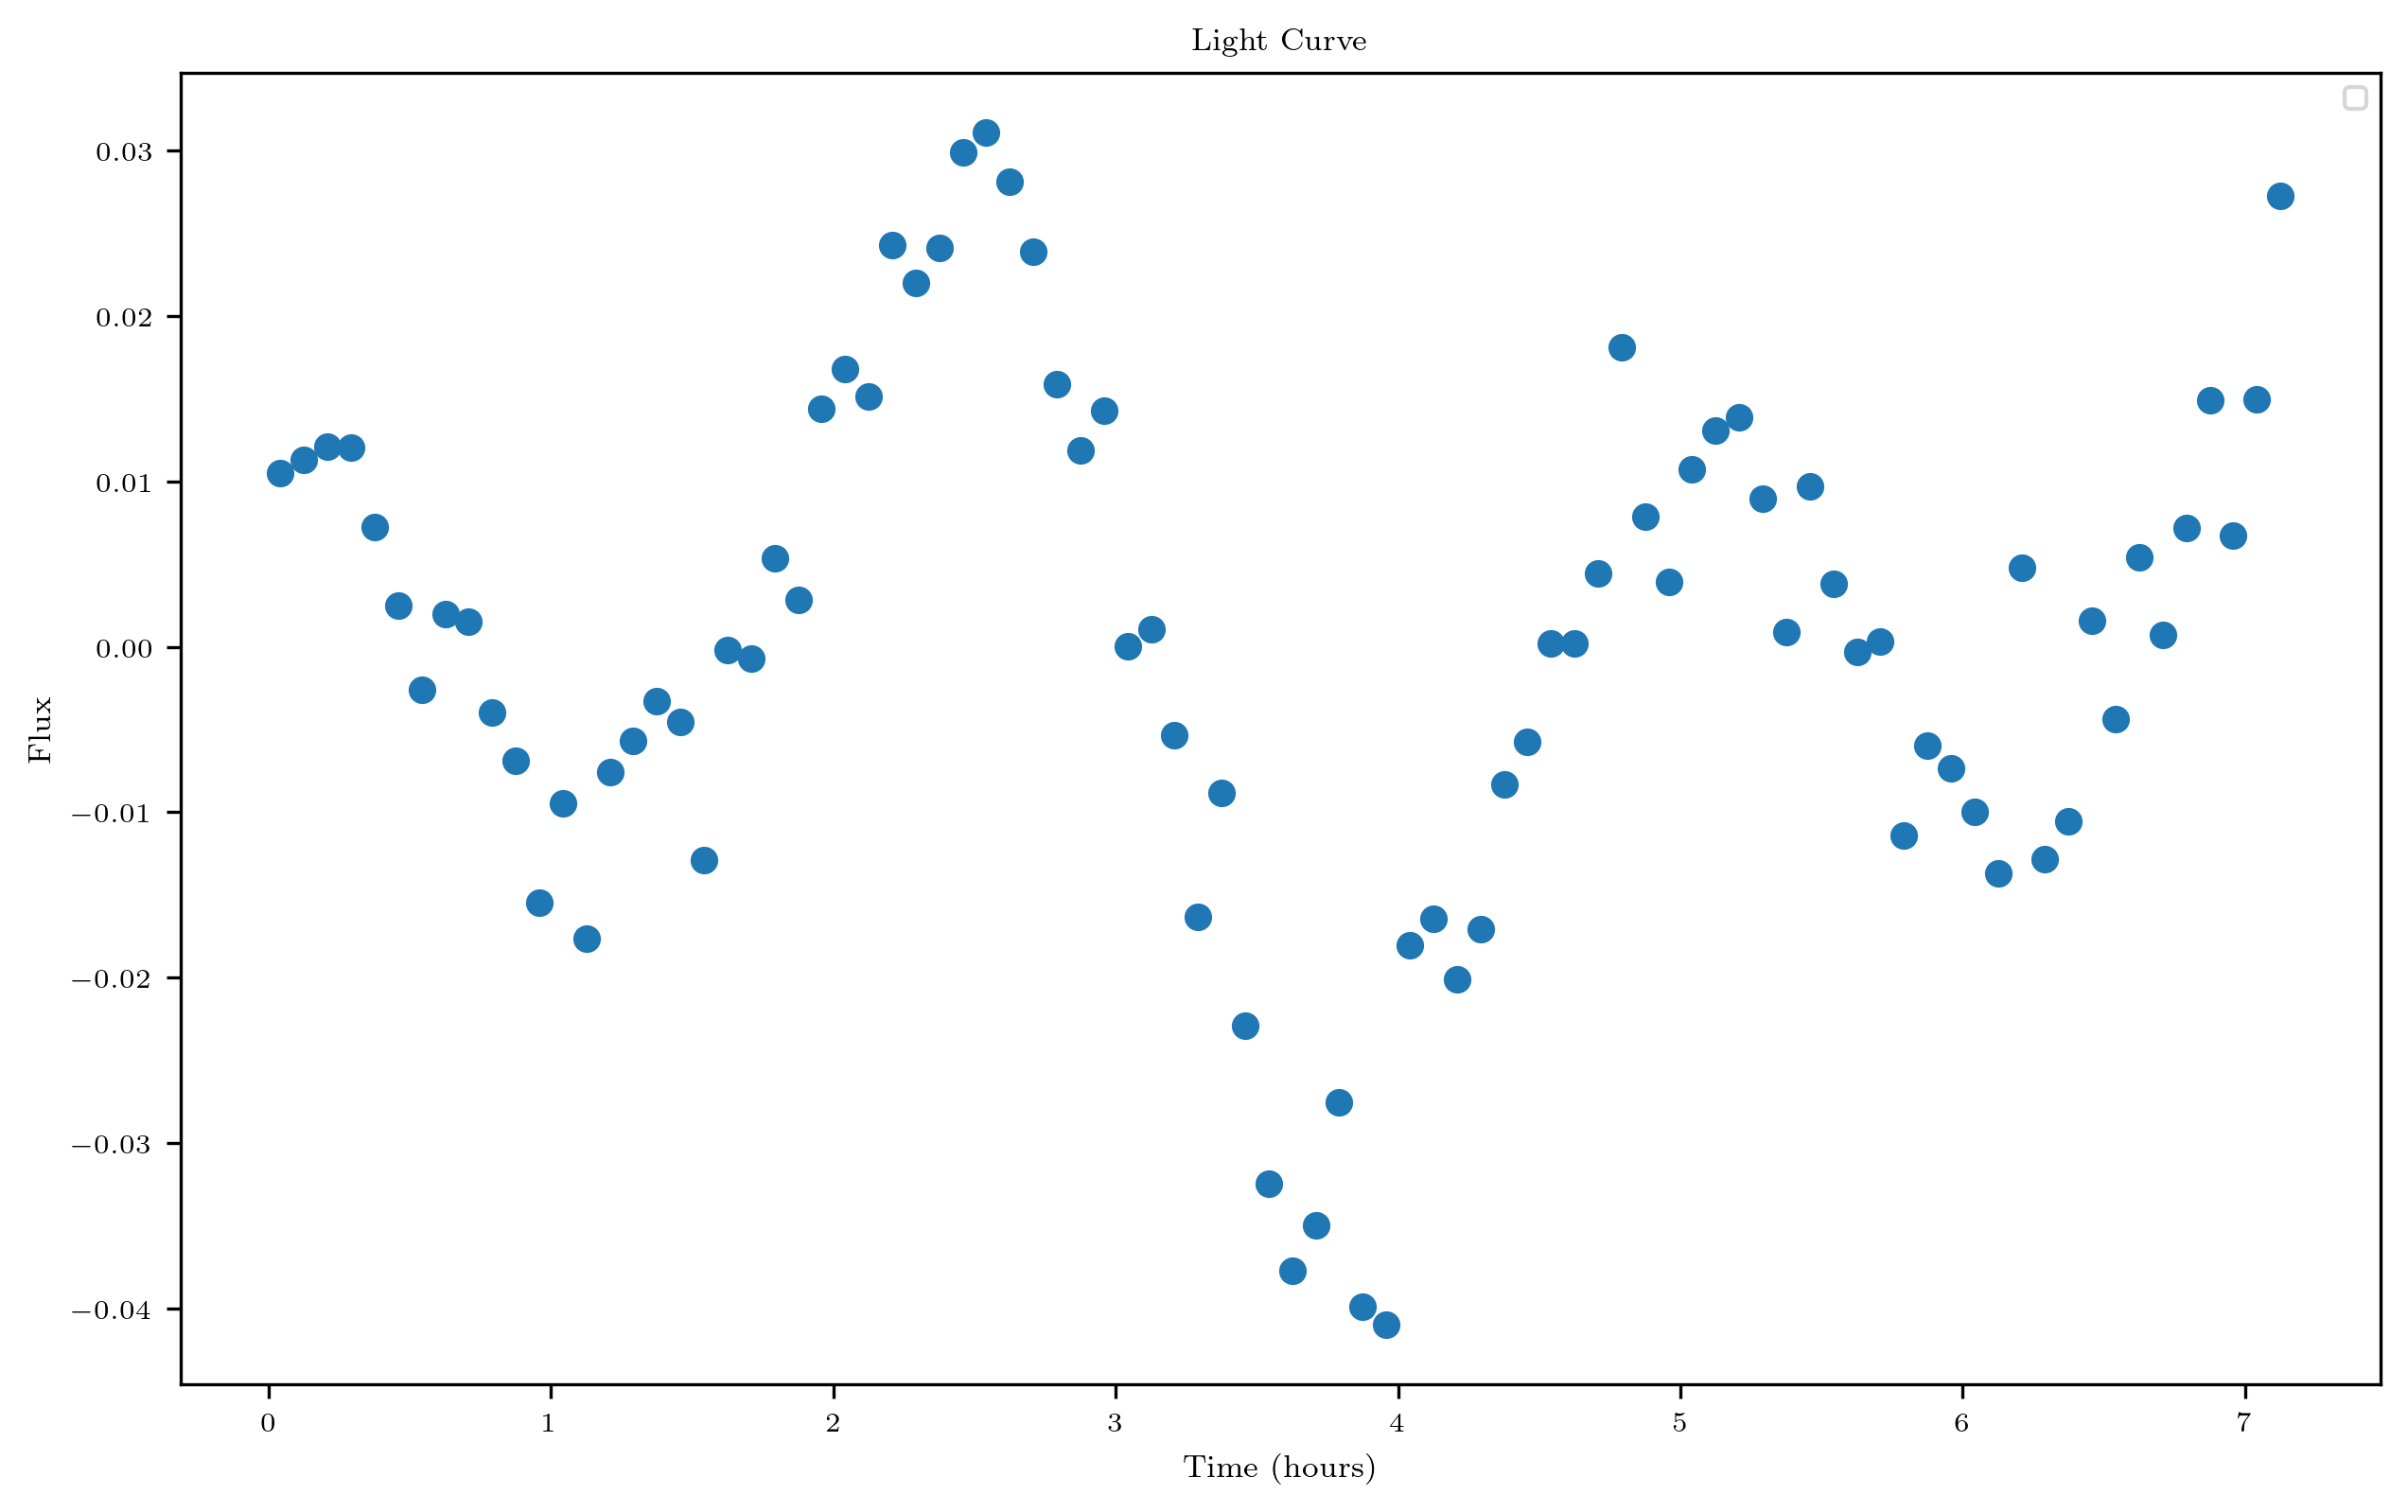

In [2]:
# Plot the White Light Curve (raw + baseline + corrected)
plt.figure(figsize=(10, 6))
plt.scatter(time, data[1, :])
plt.title(f'Light Curve')
plt.xlabel('Time (hours)')
plt.ylabel('Flux')
plt.legend()

In [ ]:
from spectralmap.mapping import Map, create_map

In [14]:
# Run rotational retrieval on one wavelength with stable hyperparameters
import numpy as np
import importlib
import spectralmap.bayesian_linalg as _bl
import spectralmap.mapping as _mp
importlib.reload(_bl)
importlib.reload(_mp)
_mp.optimize_hyperparameters = _bl.optimize_hyperparameters

# Unified API: choose mode='rotational' or mode='eclipse'
map = _mp.Map(mode='rotational')

# Rotational solver expects phase angle theta (deg), not time (hours)
theta_deg = (time / period) * 360.0

# Solver uses absolute flux baseline (~1), while `data` is normalized-1
y_obs = data[10, :] + 1.0

# Robust per-point uncertainty estimate
sigma_est = np.nanstd(np.diff(y_obs)) / np.sqrt(2.0)
if not np.isfinite(sigma_est) or sigma_est <= 0:
    sigma_est = 1e-4
sigma_y = np.full_like(y_obs, sigma_est)

# Keep fixed intensity regularization
lam_fixed = 1e3

mean_wl, cov_wl, log_ev_wl = map.solve_posterior(
    y=y_obs,
    sigma_y=sigma_y,
    theta=theta_deg,
    lam_fix=lam_fixed,
    use_alpha=True,
)

print("hyper:", map.hyper)

map.I = map.intensity_design_matrix_
I_wl = map.I @ mean_wl
I_cov_wl = map.I @ cov_wl @ map.I.T
I_sig_wl = np.sqrt(np.clip(np.diag(I_cov_wl), 0.0, None))

Optimized hyperparameters: alpha=2511.177853772831, beta=fixed, lam=1000.0, log_ev=428.86787948643735, log_ev_marginalized=429.2453502759043
Planet penalty: E=∑ a_p (I_p w)^2 = 2.947382e-03  [area=1.256228e+01 sr], 0.5*lam*E = 1.473691e+00
hyper: {'alpha': 2511.177853772831, 'beta': None, 'lam': 1000.0, 'log_ev': 428.86787948643735, 'log_ev_marginalized': 429.2453502759043, 'penalty_E': 0.0029473820576194536, 'penalty_term': 1.473691028809727, 'planet_area_sr': 12.562282556229638}


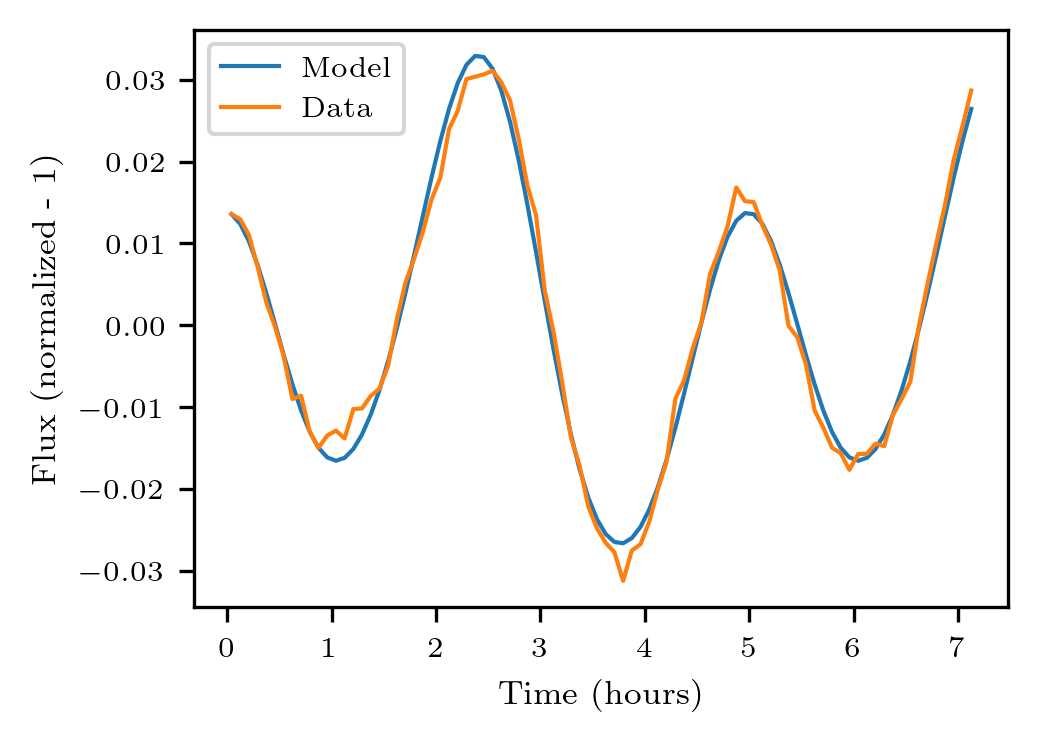

In [5]:
flux_fit = map.design_matrix_ @ mean_wl
plt.plot(time, flux_fit - 1.0, label='Model')
plt.plot(time, data[10, :], label='Data')
plt.xlabel('Time (hours)')
plt.ylabel('Flux (normalized - 1)')
plt.legend()

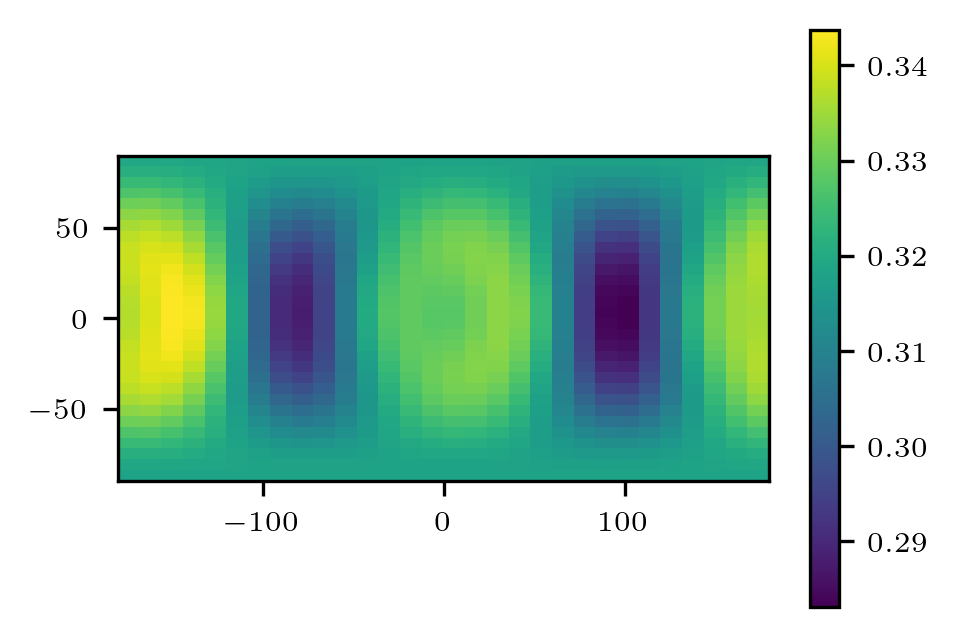

In [6]:
plt.imshow(I_wl.reshape(map.map_res, map.map_res), origin='lower', extent=(-180, 180, -90, 90))
plt.colorbar()
plt.show()

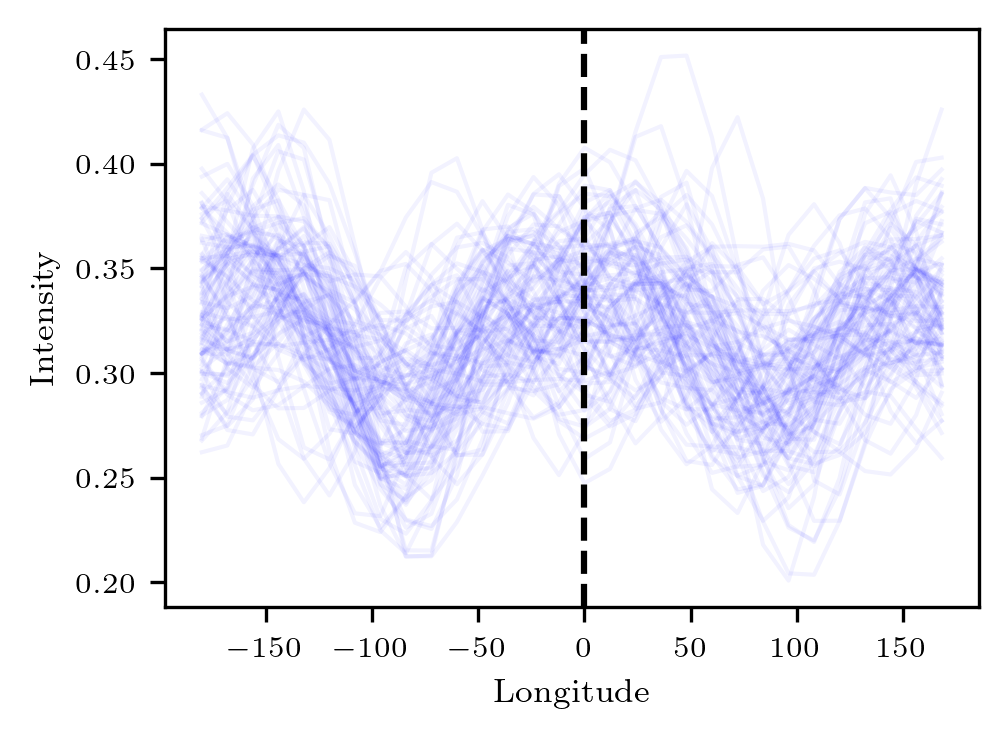

Text(0, 0.5, 'Intensity')

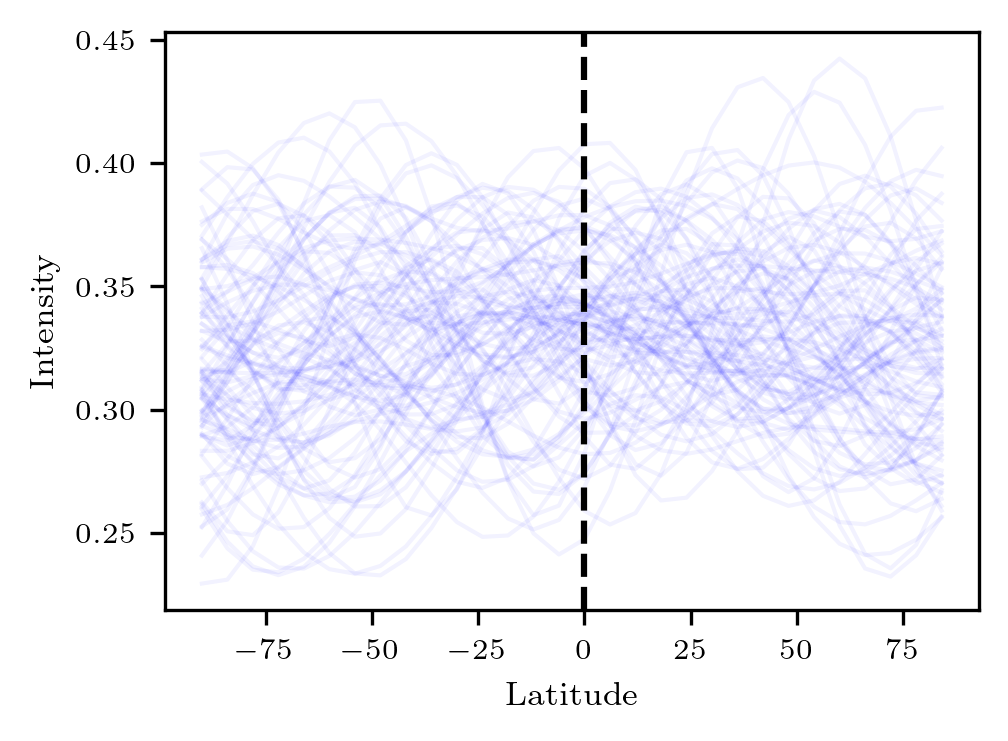

In [7]:
I_plot = I_wl
I_cov_plot = I_cov_wl
N = 100
samples = np.random.multivariate_normal(I_plot, I_cov_plot, N)

n_lat, n_lon = map.map_res, map.map_res
lons = np.unique(map.lons.flatten())
lats = np.unique(map.lats.flatten())

for i in range(N):
    plt.plot(lons, samples[i].reshape(n_lat, n_lon)[n_lat//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Longitude')
plt.ylabel('Intensity')

plt.show()
for i in range(N):
    plt.plot(lats, samples[i].reshape(n_lat, n_lon)[:, n_lon//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Latitude')
plt.ylabel('Intensity')

In [ ]:
# Run rotational retrieval on all wavelengths and store intensity means/covariances
import importlib
import numpy as np
import spectralmap.bayesian_linalg as _bl
import spectralmap.mapping as _mp
importlib.reload(_bl)
importlib.reload(_mp)
_mp.optimize_hyperparameters = _bl.optimize_hyperparameters

map_all = _mp.Map(mode='rotational', ydeg=map.ydeg, inc=map.inc, map_res=map.map_res)
I_basis = map_all.intensity_design_matrix()

# Rotational mapping expects phase angle in degrees
theta_deg_all = (time / period) * 360.0

n_wl = data.shape[0]
n_pix = I_basis.shape[0]

I_all = np.zeros((n_wl, n_pix))
I_sigma_all = np.zeros((n_wl, n_pix))
I_cov_all = np.zeros((n_wl, n_pix, n_pix))
mean_all = np.zeros((n_wl, map_all.map.Ny))
log_ev_all = np.zeros(n_wl)
hyper_all = []

lam_fixed_all = 1e5

for i_wl in range(n_wl):
    y_obs = data[i_wl, :] + 1.0
    sigma_est = np.nanstd(np.diff(y_obs)) / np.sqrt(2.0)
    if not np.isfinite(sigma_est) or sigma_est <= 0:
        sigma_est = 1e-4
    sigma_y = np.full_like(y_obs, sigma_est)

    mean_wl, cov_wl, log_ev_wl = map_all.solve_posterior(
        y=y_obs,
        sigma_y=sigma_y,
        theta=theta_deg_all,
        lam_fix=lam_fixed_all,
        use_alpha=True,
    )

    I_wl = I_basis @ mean_wl
    I_cov_wl = I_basis @ cov_wl @ I_basis.T
    I_sig_wl = np.sqrt(np.clip(np.diag(I_cov_wl), 0.0, None))

    I_all[i_wl] = I_wl
    I_sigma_all[i_wl] = I_sig_wl
    I_cov_all[i_wl] = I_cov_wl
    mean_all[i_wl] = mean_wl
    log_ev_all[i_wl] = log_ev_wl
    hyper_all.append(dict(map_all.hyper))

print(f"Computed all wavelengths: n_wl={n_wl}, n_pix={n_pix}")
print(f"I_all shape={I_all.shape}, I_sigma_all shape={I_sigma_all.shape}, I_cov_all shape={I_cov_all.shape}")
print("alpha range:", np.min([np.ravel(h['alpha'])[0] if np.ndim(h['alpha'])==0 else np.nanmin(np.asarray(h['alpha'])) for h in hyper_all]), np.max([np.ravel(h['alpha'])[0] if np.ndim(h['alpha'])==0 else np.nanmax(np.asarray(h['alpha'])) for h in hyper_all]))

Optimized hyperparameters: alpha=12161.167414831167, beta=fixed, lam=100000.0, log_ev=290.0896093106195, log_ev_marginalized=290.48369262086277
Planet penalty: E=∑ a_p (I_p w)^2 = 5.683456e-04  [area=1.256228e+01 sr], 0.5*lam*E = 2.841728e+01
Optimized hyperparameters: alpha=6259.3626812441125, beta=fixed, lam=100000.0, log_ev=307.66938148147995, log_ev_marginalized=308.0489480648633
Planet penalty: E=∑ a_p (I_p w)^2 = 1.172854e-03  [area=1.256228e+01 sr], 0.5*lam*E = 5.864269e+01
Optimized hyperparameters: alpha=4652.3846923640085, beta=fixed, lam=100000.0, log_ev=313.561761361628, log_ev_marginalized=313.9378376506386
Planet penalty: E=∑ a_p (I_p w)^2 = 1.600556e-03  [area=1.256228e+01 sr], 0.5*lam*E = 8.002781e+01
Optimized hyperparameters: alpha=4319.301360762355, beta=fixed, lam=100000.0, log_ev=309.47937987357966, log_ev_marginalized=309.85484903991716
Planet penalty: E=∑ a_p (I_p w)^2 = 1.728125e-03  [area=1.256228e+01 sr], 0.5*lam*E = 8.640624e+01
Optimized hyperparameters: alp

Explained Variance Ratio (PC1, PC2): [0.8602039  0.12008108]
Step 1 (Corners: 17): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 2 (Corners: 16): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 3 (Corners: 15): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 4 (Corners: 14): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 5 (Corners: 13): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 6 (Corners: 12): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 7 (Corners: 11): Loss 2 vs Prev 2 (Ratio: 1.0)
Step 8 (Corners: 10): Loss 6 vs Prev 2 (Ratio: 3.0)
Step 9 (Corners: 9): Loss 8 vs Prev 6 (Ratio: 1.3)
Step 10 (Corners: 8): Loss 9 vs Prev 8 (Ratio: 1.1)
Step 11 (Corners: 7): Loss 10 vs Prev 9 (Ratio: 1.1)
Step 12 (Corners: 6): Loss 10 vs Prev 10 (Ratio: 1.0)
Step 13 (Corners: 5): Loss 46 vs Prev 10 (Ratio: 4.6)
Step 14 (Corners: 4): Loss 75 vs Prev 46 (Ratio: 1.6)
Step 15 (Corners: 3): Loss inf vs Prev 75 (Ratio: inf)
-> Elbow detected at 3 corners!
-1 600
0 100
1 100
2 100
Observable pixels: 900 of 900
F_regionals shape: (4, 334)
F_regional_errs shape: (4, 334)
lab

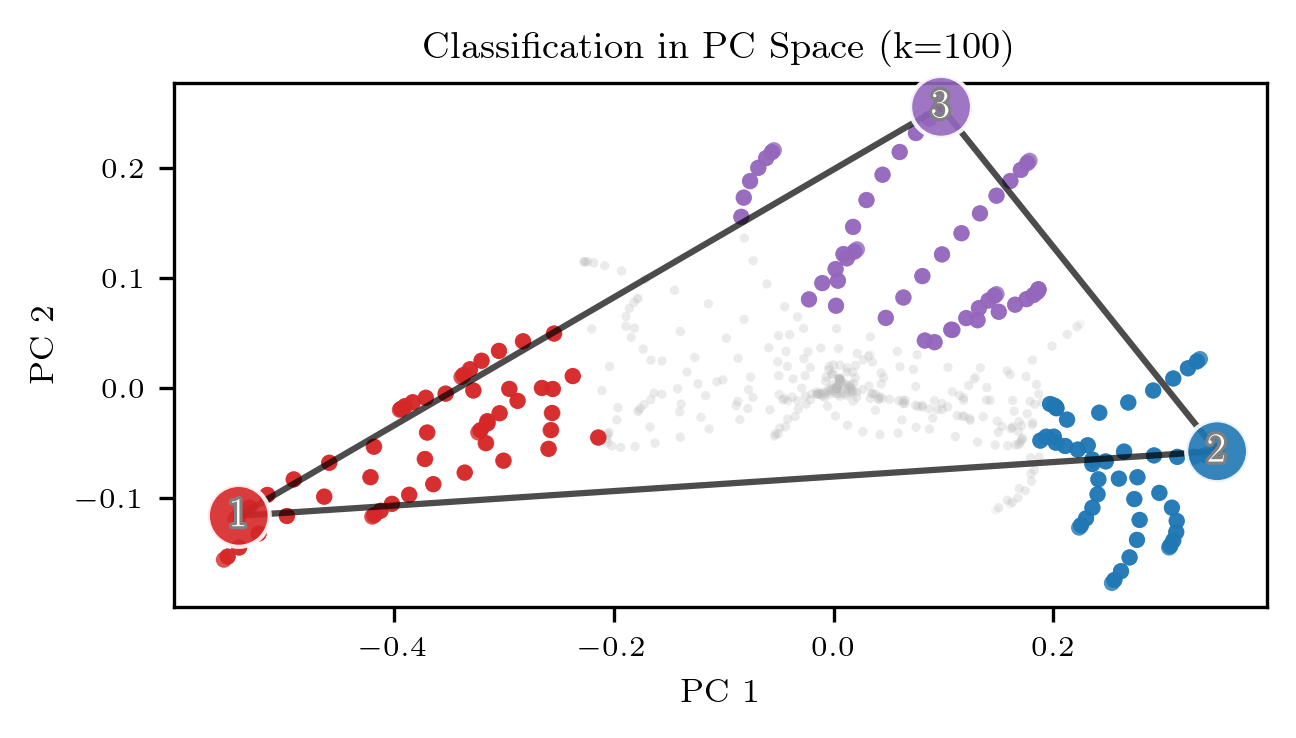

In [9]:
from spectralmap.cluster import find_clusters
import spectralmap.cluster as _cl
import spectralmap.bayesian_linalg as _bl
import spectralmap.mapping as _mp
import importlib
importlib.reload(_bl)
importlib.reload(_mp)
importlib.reload(_cl)

# Full rotational map is observable
lons = map_all.lons.flatten()
day_mask = np.ones_like(lons, dtype=bool)
UNOBS_LABEL = -999

# Keep a clipped copy for clustering stability, and cluster only observable pixels
I_all_clip = np.maximum(I_all, 1e-5)
I_obs = I_all_clip[:, day_mask]
I_cov_obs = I_cov_all[:, day_mask][:, :, day_mask]

F_regionals, F_regional_errs, labels_obs = find_clusters(
    I_obs * np.pi,
    I_cov_obs * np.pi ** 2,
    sensitivity=5,
    n_neighbors=100,
)

# Expand labels back to full map, using a separate sentinel for unobservable pixels
labels = np.full(day_mask.shape[0], UNOBS_LABEL, dtype=int)
labels[day_mask] = labels_obs

print('Observable pixels:', int(day_mask.sum()), 'of', day_mask.size)
print('F_regionals shape:', F_regionals.shape)
print('F_regional_errs shape:', F_regional_errs.shape)
print('labels unique (full map):', np.unique(labels))
print('labels unique (observable only):', np.unique(labels[day_mask]))

# Keep outputs in normalized units by default (recommended for Fp/Fs plots)
rescale_to_absolute = True
if rescale_to_absolute:
    F_regionals *= amplitudes
    F_regional_errs *= amplitudes

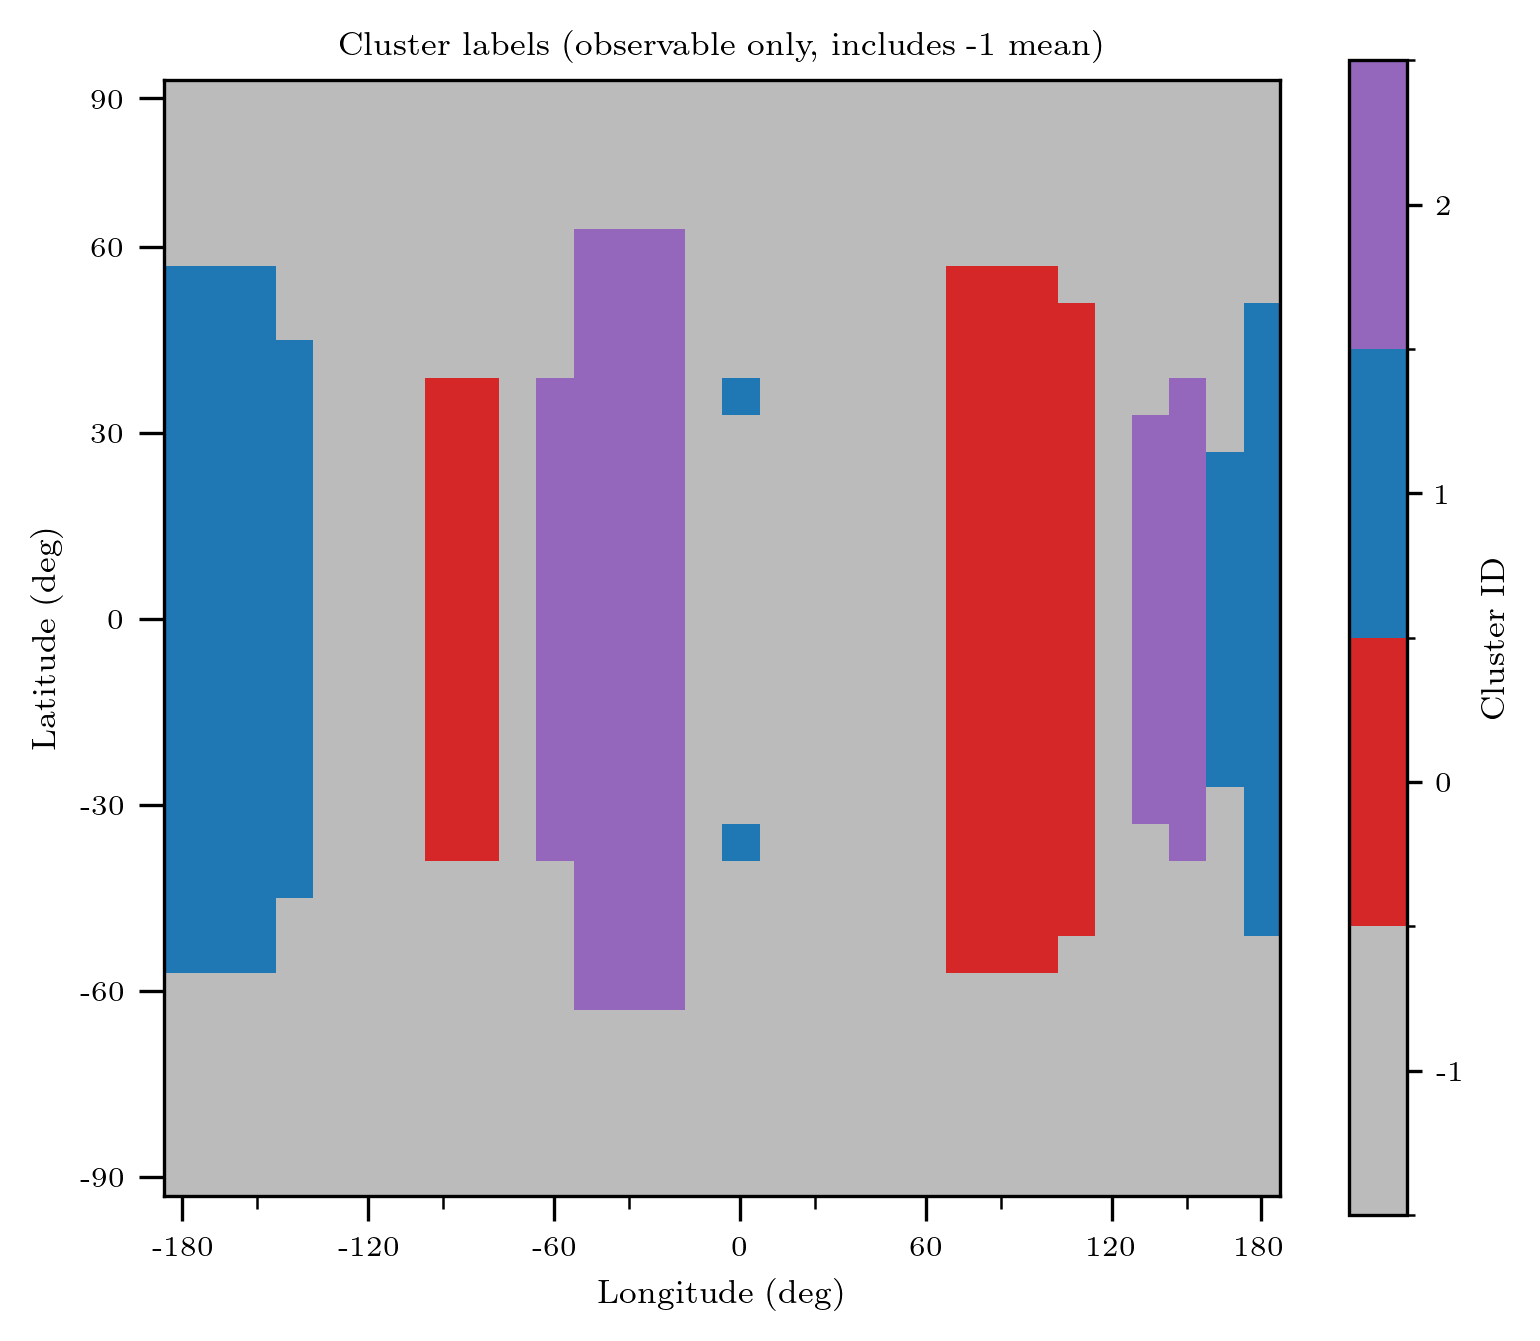

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

labels_2d = labels.reshape(30, 30)
UNOBS_LABEL = -999

# Plot ONLY observable part, but keep all observable label values (including -1)
labels_obs_flat = labels[labels != UNOBS_LABEL]
uniq = np.unique(labels_obs_flat)

# Build a display map with compact color indices; unobservable stays masked
display = np.full_like(labels_2d, fill_value=-1, dtype=int)
label_to_idx = {lab: i for i, lab in enumerate(uniq)}
for lab, idx in label_to_idx.items():
    display[labels_2d == lab] = idx

display_masked = np.ma.masked_where(display < 0, display)

cluster_colors = ['#BBBBBB', '#D62728', '#1F77B4', '#9467BD', '#2CA02C', '#FF7F0E', '#8C564B']
if len(uniq) > len(cluster_colors):
    cluster_colors = [plt.cm.tab20(i / max(len(uniq) - 1, 1)) for i in range(len(uniq))]
else:
    cluster_colors = cluster_colors[:len(uniq)]

cmap = ListedColormap(cluster_colors)
boundaries = np.arange(-0.5, len(uniq) + 0.5, 1)
norm = BoundaryNorm(boundaries, cmap.N)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(display_masked, origin='lower', cmap=cmap, norm=norm)
ax.set_title('Cluster labels (observable only, includes -1 mean)')

# Show physical coordinate labels (lon/lat) instead of pixel indices
lons_2d = map_all.lons
lats_2d = map_all.lats

# Symmetric major ticks
lon_major = np.array([-180, -120, -60, 0, 60, 120, 180])
lat_major = np.array([-90, -60, -30, 0, 30, 60, 90])

# Minor ticks every 30 deg
lon_minor = np.arange(-180, 181, 30)
lat_minor = np.arange(-90, 91, 30)

x_major_idx = [int(np.argmin(np.abs(lons_2d[0, :] - val))) for val in lon_major]
y_major_idx = [int(np.argmin(np.abs(lats_2d[:, 0] - val))) for val in lat_major]
x_minor_idx = [int(np.argmin(np.abs(lons_2d[0, :] - val))) for val in lon_minor]
y_minor_idx = [int(np.argmin(np.abs(lats_2d[:, 0] - val))) for val in lat_minor]

ax.set_xticks(x_major_idx)
ax.set_yticks(y_major_idx)
ax.set_xticklabels([f'{v:d}' for v in lon_major])
ax.set_yticklabels([f'{v:d}' for v in lat_major])

ax.set_xticks(x_minor_idx, minor=True)
ax.set_yticks(y_minor_idx, minor=True)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)

ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

cbar = fig.colorbar(im, ax=ax, ticks=np.arange(len(uniq)))
cbar.ax.set_yticklabels([str(int(lab)) for lab in uniq])
cbar.set_label('Cluster ID')

plt.show()

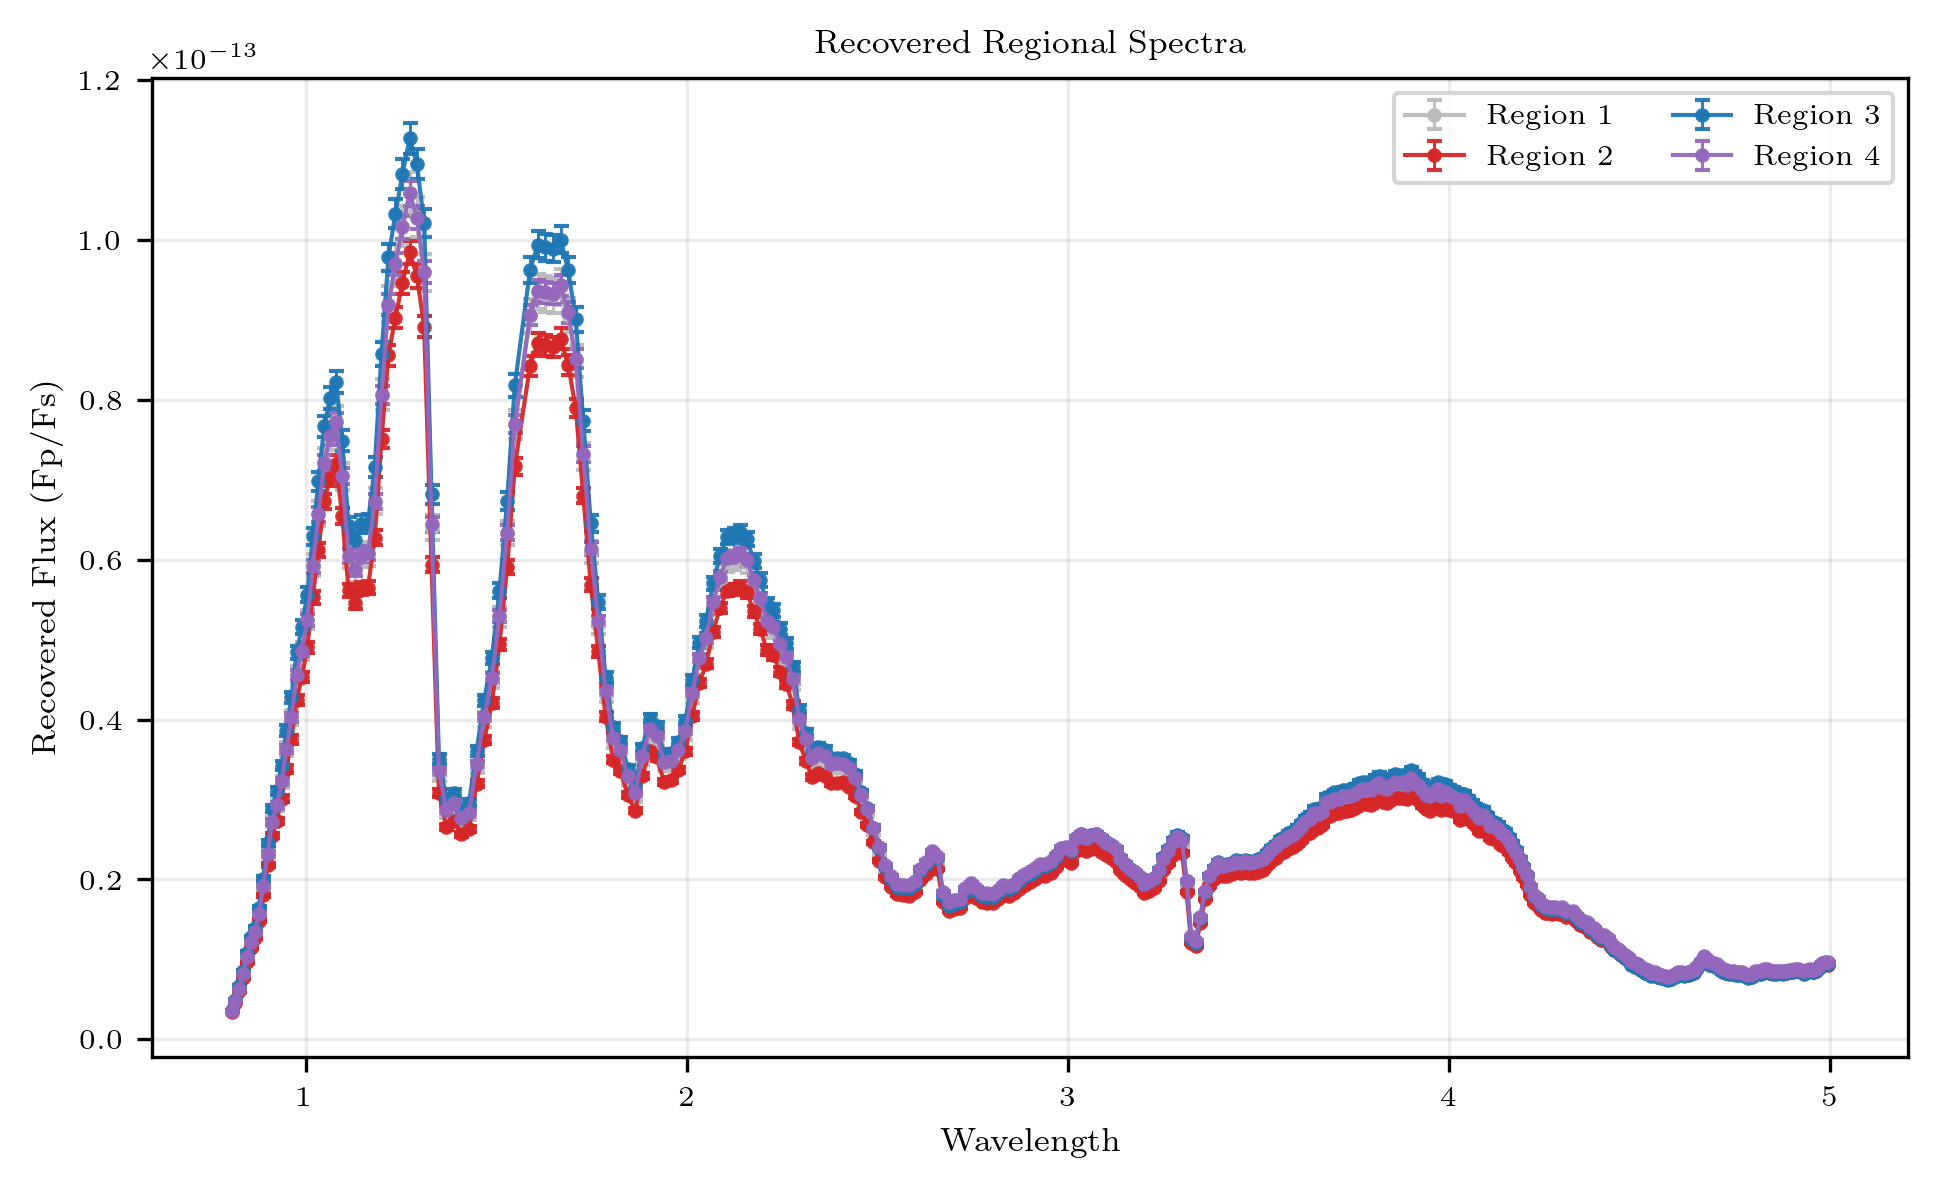

In [11]:
# Plot recovered regional spectra with 1-sigma error bars
wls = np.asarray(wl_B).ravel()
n_spec = F_regionals.shape[1]
if wls.size != n_spec:
    wls = np.linspace(np.nanmin(wl_B), np.nanmax(wl_B), n_spec)

plt.figure(figsize=(6.5, 4.0))
base_colors = ['#BBBBBB', '#D62728', '#1F77B4', '#9467BD', '#2CA02C', '#FF7F0E', '#8C564B']

for i_reg in range(F_regionals.shape[0]):
    c = base_colors[i_reg % len(base_colors)]
    plt.errorbar(
        wls,
        F_regionals[i_reg],
        yerr=F_regional_errs[i_reg],
        fmt='o-',
        ms=2.5,
        lw=1.0,
        elinewidth=0.7,
        capsize=1.8,
        color=c,
        alpha=0.95,
        label=f'Region {i_reg+1}'
    )

plt.xlabel('Wavelength')
plt.ylabel('Recovered Flux (Fp/Fs)')
plt.title('Recovered Regional Spectra')
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=True)
plt.tight_layout()
plt.show()